# PPO Fine-Tuning on AWS SageMaker

This notebook launches a SageMaker training job to fine-tune the Qwen2-7B-Instruct model using Proximal Policy Optimization (PPO) for the Countdown math problem task.

***Cost Optimization***

- Using spot instances (up to 70% cheaper than on-demand)
- QLoRA for efficient fine-tuning (reduces memory requirements)
- Checkpointing to resume training if interrupted

In [22]:
# Install required packages
!pip install -q sagemaker boto3

In [23]:
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
import time
import os
import warnings
warnings.filterwarnings('ignore')
import torch
import transformers
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")

PyTorch version: 2.4.1.post100
Transformers version: 4.49.0


## 1. Set up SageMaker session

In [ ]:
# Set up SageMaker session
role = get_execution_role()
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'countdown-ppo'

print(f"SageMaker Role ARN: {role}")
print(f"SageMaker Session Region: {session.boto_region_name}")
print(f"S3 Bucket: {bucket}")

## 2. Define hyperparameters

✅ Key Facts

- ***Constraint (PPO trainer requires that:): batch_size must be divisible by mini_batch_size * gradient_accumulation_steps***

- **Dataset:** `predibase/countdown`  
  - **Training set:** 1,000 samples  
  - **Test set:** 500 samples  

- **Model:** `Qwen/Qwen2.5-0.5B-Instruct`  
  - Small (≈0.9 GB), fine-tunable on consumer or cloud GPUs  

- **GPU:** `ml.g5.2xlarge` (NVIDIA A10G, 24GB VRAM)  

- **Framework:** `trl` PPOTrainer  
  - Requires:  
    \[
    \text{batch\_size} \mod (\text{mini\_batch\_size} \times \text{gradient\_accumulation\_steps}) = 0
    \]

---

🎯 Recommended Hyperparameters (Satisfying PPOTrainer Constraint)

Let’s define:

- `mini_batch_size = 4`  
- `gradient_accumulation_steps = 2`  
Then:
- `mini_batch_size * gradient_accumulation_steps = 8`  
So, choose a `batch_size` divisible by 8, such as **16**, **32**, etc.

✅ Safe, efficient choice:
```python
hyperparameters = {
    'base-model': 'Qwen/Qwen2.5-0.5B-Instruct',
    'lora-r': 16,
    'lora-alpha': 32,
    'lora-dropout': 0.05,
    'learning-rate': 1.41e-5,
    'max-steps': 200,          # Slightly over 3 epochs (based on 1,000 training samples)
    'save-steps': 50,

    'batch-size': 16,          # Must be divisible by 4 * 2
    'mini-batch-size': 4,      # Each PPO step uses this many samples
    'gradient-accumulation-steps': 2
}
```

---

🧮 Training Logic Behind the Numbers

- With `batch_size = 16`, and 1,000 training samples:
  - Each **epoch** ≈ 63 steps  
  - `max_steps = 200` → ~3.17 epochs  

- PPO divides `batch_size` into `mini_batch_size` segments:
  - Here: 16 / 4 = 4 mini-batches per PPO step  
  - Each gradient update accumulates over 2 steps

---

### 🧠 Pro Tips

- If CUDA OOM occurs:
  - Reduce `batch_size` to 8 or 4
  - Adjust `mini_batch_size` and `gradient_accumulation_steps` accordingly  
    (e.g., 4 = 2 × 2 or 2 = 1 × 2)

- If GPU is underutilized:
  - Increase `batch_size` to 32 or 64 (just ensure divisibility)

**🧠 PPO Training: Valid Batch Configurations (Ensure:** `batch_size % (mini_batch_size × gradient_accum_steps) == 0` **)**

| `batch_size` | `gradient_accum_steps` | `mini_batch_size` | `batch_size ÷ (g.a. × m.b.s)` | Safe?                         |
|--------------|------------------------|--------------------|-------------------------------|-------------------------------|
| 1            | 1                      | 1                  | 1                             | ✅ Yes — very slow            |
| 2            | 1                      | 1                  | 2                             | ✅ Yes                        |
| 4            | 1                      | 1                  | 4                             | ✅ Good starter config        |
| 8            | 1                      | 2                  | 4                             | ✅ Okay — monitor VRAM        |
| 8            | 2                      | 2                  | 2                             | ✅ Stable + balanced          |
| 16           | 2                      | 4                  | 2                             | ✅ Best trade-off             |
| 32           | 2                      | 4                  | 4                             | ❌ May OOM on 16GB GPUs       |
| 32           | 4                      | 4                  | 2                             | ✅ Good on 24GB+ GPUs         |
| 64           | 4                      | 8                  | 2                             | ❌ Likely OOM on 24GB GPU     |





In [ ]:
# Define hyperparameters
## Test Training only!
# hyperparameters = {
#     'base-model': 'Qwen/Qwen2-1.5B-Instruct', # Cahnged from 'Qwen/Qwen2-7B-Instruct'
#     'lora-r': 16,
#     'lora-alpha': 32,
#     'lora-dropout': 0.05,
#     'learning-rate': 1.41e-5,
#     'max-steps': 1,  # Reduce this for testing or cost savings (original= 100 or 1000)
#     'save-steps': 100,
#     'batch-size': 1, # Reduce this for testing or cost savings (original= 100 or 1000)
#     'gradient-accumulation-steps': 1 # Reduce this for testing or cost savings (original= 4)
# }

## Real Training (no training plots needed)
# hyperparameters = {
#     'base-model': 'Qwen/Qwen2-1.5B-Instruct',  # ✅ still a good choice
#     'lora-r': 16,
#     'lora-alpha': 32,
#     'lora-dropout': 0.05,
#     'learning-rate': 1.41e-5,
#     'max-steps': 200,                   # 🔼 reasonable for 30–60 min of training
#     'save-steps': 50,                   # 🧠 save intermediate checkpoints
#     'batch-size': 4,                    # 🔼 GPU can handle this; increase if room
#     'gradient-accumulation-steps': 1    # 🧠 keeps memory use lower, effective batch = 8
# }

## Real Training (with training plots)
hyperparameters = {
    'base-model': 'Qwen/Qwen2.5-0.5B-Instruct',
    'lora-r': 16,
    'lora-alpha': 32,
    'lora-dropout': 0.05,
    'learning-rate': 1.41e-5,
    'max-steps': 200,          # Slightly over 3 epochs (based on 1,000 training samples)
    'save-steps': 50,

    'batch-size': 16,          # Must be divisible by (mini-batch-sizeXgradient-accumulation-steps)= 4 * 2
    'mini-batch-size': 4,      
    'gradient-accumulation-steps': 2,
}


## 3. Create PyTorch estimator

We'll use a PyTorch estimator with spot instances for cost savings.

In [ ]:
from sagemaker.pytorch import PyTorch

# Create PyTorch estimator
# Configure SageMaker training job with Spot Instances for cost savings

## CPU only
# estimator = PyTorch(
#     entry_point='train-diag.py',
#     source_dir='.',                         # this is where requirements.txt is
#     role=role,
#     framework_version='2.4.0',
#     py_version='py311',
#     instance_count=1,
#     instance_type='ml.m5.large',   # Revert to 'ml.g5.2xlarge' after debug
#     hyperparameters=hyperparameters,
#     max_run=1800,
#     use_spot_instances=False,      # Revert to True after debug
#     #max_wait=72*60*60,
#     checkpoint_s3_uri=f's3://{bucket}/{prefix}/checkpoints',
#     checkpoint_local_path='/opt/ml/checkpoints',
#     dependencies=['.'],  # this tells SageMaker to install requirements.txt before running train.py
# )


## Small GPU, no spot instance
# estimator = PyTorch(
#     entry_point='train-diag.py',
#     source_dir='.',                          # location of train-diag.py and requirements.txt
#     role=role,
#     framework_version='2.4.0',
#     py_version='py311',
#     instance_count=1,
#     instance_type='ml.g5.xlarge',            # upgraded from ml.m5.large
#     hyperparameters=hyperparameters,
#     max_run=1800,                            # 30 minutes for fast debug
#     use_spot_instances=False,                # switch to True for cost savings after debug
#     checkpoint_s3_uri=f's3://{bucket}/{prefix}/checkpoints',
#     checkpoint_local_path='/opt/ml/checkpoints',
#     dependencies=['.'],                      # install requirements.txt
# )

## Large GPU, with spot instance
estimator = PyTorch(
    entry_point='train.py',
    source_dir='.',
    role=role,
    framework_version='2.4.0',
    py_version='py311',
    instance_count=1,
    instance_type='ml.g5.2xlarge',             # or 'ml.g5.12xlarge'
    hyperparameters=hyperparameters,
    max_run=72*60*60,
    use_spot_instances=False,                   # ✅ Enable spot for savings
    # max_wait=72*60*60,                         # ✅ Must be included when using spot
    checkpoint_s3_uri=f's3://{bucket}/{prefix}/checkpoints',
    checkpoint_local_path='/opt/ml/checkpoints',
    dependencies=['.'],
)

## 4. Start training

This will launch the training job on SageMaker. The job will run on the specified instance type and use the hyperparameters defined above.

In [ ]:
## Real Training (with training plots)
hyperparameters = {
    'base-model': 'Qwen/Qwen2.5-0.5B-Instruct',
    'lora-r': 16,
    'lora-alpha': 32,
    'lora-dropout': 0.05,
    'learning-rate': 1.41e-5,
    'max-steps': 200,          # Slightly over 3 epochs (based on 1,000 training samples)
    'save-steps': 50,

    'batch-size': 16,          # Must be divisible by (mini-batch-sizeXgradient-accumulation-steps)= 4 * 2
    'mini-batch-size': 4,      
    'gradient-accumulation-steps': 2,
}


## Large GPU, with spot instance
estimator = PyTorch(
    entry_point='train.py',
    source_dir='.',
    role=role,
    framework_version='2.4.0',
    py_version='py311',
    instance_count=1,
    instance_type='ml.g5.2xlarge',             # or 'ml.g5.12xlarge'
    hyperparameters=hyperparameters,
    max_run=72*60*60,
    use_spot_instances=False,                   # ✅ Enable spot for savings
    # max_wait=72*60*60,                         # ✅ Must be included when using spot
    checkpoint_s3_uri=f's3://{bucket}/{prefix}/checkpoints',
    checkpoint_local_path='/opt/ml/checkpoints',
    dependencies=['.'],
)

# Start training
print("Starting training job...")
estimator.fit(wait=True, logs=True)

### **Training Highlights Summary**

1. **Training Start and Configuration**  
   The training job began successfully using the `Qwen/Qwen2.5-0.5B-Instruct` model with LoRA applied. Key hyperparameters included:
   - `learning_rate`: 1.41e-5  
   - `max_steps`: 200  
   - `batch_size`: 16  
   - `mini_batch_size`: 4  
   - `gradient_accumulation_steps`: 2  
   - `lora_r`: 16, `lora_alpha`: 32, `lora_dropout`: 0.05  

   The system also used a G5 GPU (`ml.g5.2xlarge`) without spot interruptions. Training utilized the `transformers`, `trl`, `peft`, and `datasets` libraries under a stable PyTorch and SageMaker environment.

2. **Execution Timeline**  
   The training progressed from step 0 to step 62 before early termination. Although `max_steps` was set to 200, the job completed prematurely. The job was marked as **successful** (return code 0) by SageMaker, implying that no internal error caused the interruption—likely a timeout or manual stop.

3. **Logging and Checkpointing**  
   - Logs were saved every 10 steps, and the model was checkpointed at step 60.  
   - A TensorBoard writer was initialized and successfully closed at the end.  
   - `ppo_training_log.csv` was saved under `/opt/ml/model`, ensuring reward logs were preserved.

4. **Reward Signals**  
   The **mean reward remained at `0.00` for all 63 logged steps (0–62)**:
   - Format reward and equation reward functions were unable to yield a single positive signal.
   - This suggests that the model’s completions never satisfied the structure or arithmetic correctness defined by your two reward functions.
   - Consequently, **no reinforcement signal was given** to guide learning, resulting in ineffective PPO optimization.

5. **Successful Completion**  
   Despite zero learning signal, the training loop finished gracefully:
   - Logs were flushed and saved properly.
   - The model and tokenizer were serialized to disk.
   - SageMaker reported the training job as “**SUCCESS**.”

---

### **Implications and Recommendations**

- The **lack of positive rewards** implies either:
  - The reward functions are too strict or misaligned with what the model can produce early in training.
  - The model wasn't warm-started properly or initialized with sufficient knowledge to generate structurally valid outputs.
  
- Consider:
  - Lowering the reward function constraints (e.g., accept partial matches, use fuzzy logic).
  - Starting with on-demand instances for short debugging runs (10–20 steps) to verify learning signals.
  - Training with supervised learning or reward shaping for a few epochs before applying PPO.


### 5. **Post-Training Visualization: Download and Plot PPO Reward Curves**

This cell performs three key actions after your SageMaker training job has finished:

1. **Retrieves metadata** from the completed training job, including the job name and the S3 location where model artifacts and logs are stored.
2. **Downloads output artifacts** (such as logs) from the `output/data` directory of the training job into a local folder using SageMaker's `download_artifact()` method.
3. **Loads and visualizes** the `ppo_training_log.csv` file that was generated during training, which contains step-wise reward values (format reward, equation reward, and total reward). These values are plotted to help analyze how the model’s reward performance evolved over time.

This cell enables a clear post-hoc assessment of your RLHF training dynamics without requiring live monitoring. The resulting plot gives insight into how well your model learned over training steps and whether the reward signals (formatting and equation accuracy) improved.

If no CSV file is found, the cell will provide a helpful message indicating where to check for issues.

In [ ]:
import tarfile
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Get training job info ---
training_job_name = estimator.latest_training_job.name
model_artifacts = estimator.model_data
print(f"Job name: {training_job_name}")
print(f"Model artifacts: {model_artifacts}")

# --- Download model.tar.gz ---
bucket = model_artifacts.split("/")[2]
key = "/".join(model_artifacts.split("/")[3:])
local_tar_path = f"./artifacts/{training_job_name}/model.tar.gz"
os.makedirs(os.path.dirname(local_tar_path), exist_ok=True)

boto3.client("s3").download_file(bucket, key, local_tar_path)

# --- Extract reward CSV ---
extract_path = f"./artifacts/{training_job_name}/extracted"
os.makedirs(extract_path, exist_ok=True)
with tarfile.open(local_tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

csv_path = os.path.join(extract_path, "ppo_training_log.csv")

# --- Plot reward curves ---
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)

    if len(df) > 500:
        df = df.groupby("step").mean().reset_index()

    plt.figure(figsize=(10, 6))
    plt.plot(df["step"], df["format_reward"], label="Format Reward")
    plt.plot(df["step"], df["equation_reward"], label="Equation Reward")
    plt.plot(df["step"], df["total_reward"], label="Total Reward")
    plt.xlabel("Training Step")
    plt.ylabel("Reward")
    plt.title("PPO Rewards over Training")
    plt.legend()
    plt.grid(True)

    plot_path = os.path.join(extract_path, "reward_plot.png")
    plt.savefig(plot_path, dpi=300)
    print(f"📈 Plot saved to: {plot_path}")
    plt.show()
else:
    print("🚫 Log file not found.")


## 6. Evaluate the model

After training completes, you can download the model and evaluate it using the evaluate.py script.

### 6.1 Run Evaluation on the Extracted Model

This step generates a JSON file (evaluation_results.json) containing metrics + completions on test examples.

In [39]:
# !pip install peft datasets pyarrow --quiet

!python evaluate.py \
    --model-dir ./artifacts/{training_job_name}/extracted \
    --base-model {hyperparameters['base-model']} \
    --output-file evaluation_results.json


2025-04-10 09:00:25.236167: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
📥 Loading dataset with schema workaround...
Direct download failed: 404 Client Error. (Request ID: Root=1-67f788b3-1839b4da418dae3d1f75f572;b68b0506-dd69-4ea3-8ecb-1dea26085f7b)

Entry Not Found for url: https://huggingface.co/datasets/predibase/countdown/resolve/main/test.parquet.
Falling back to manual download...
🚀 Loading model: Qwen/Qwen2.5-0.5B-Instruct
Created temporary offload directory: /tmp/tmpr4jult_o
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading adapter from: ./artifacts/pytorch-training-2025-04-10-07-57-35-919/extracted
Some parameters are on the meta device because they we

### 6.2 Analyze & Visualize Evaluation Results
This script performs **post-evaluation analysis** on the model's performance:

1. **Loads** the `evaluation_results.json` file produced by `evaluate.py`.
2. **Prints** overall evaluation metrics (e.g., average format and equation scores).
3. **Displays**:
   - The **worst-performing** example (lowest combined reward).
   - The **best-performing** example (highest combined reward).
4. **Plots histograms** to visualize the distribution of:
   - Format scores
   - Equation scores

In short, it gives you both **quantitative metrics** and **qualitative insight** into how well your trained model is reasoning and calculating.

📊 Evaluation Metrics:
avg_format_score: 0.0000
avg_equation_score: 0.0000
combined_score: 0.0000
num_examples: 5

❌ Example with lowest score:
{
  "prompt": "<|im_start|>system\nYou are a helpful assistant. You first think about the reasoning process step by step and then provide the user with an answer.<|im_end|>\n<|im_start|>user\nUsing the numbers [1, 2, 3, 4], create an equation that equals 24. You can use basic arithmetic operations (+, -, *, /) and parentheses, and each number can only be used once. Show your work in <think> </think> tags. And return the final equation and answer in <answer> </answer> tags, for example <answer> (1 + 2) / 3 </answer>.<|im_end|>\n<|im_start|>assistant\nLet me solve this step by step.\n<think>",
  "completion": " First, I'll try to maximize the left side of the equation using addition. Since we have four numbers, I'll start by adding the largest two together: 4 + 3 = 7. This leaves us with 24 - 7 = 17. Now I need to balance the equation by subtracti

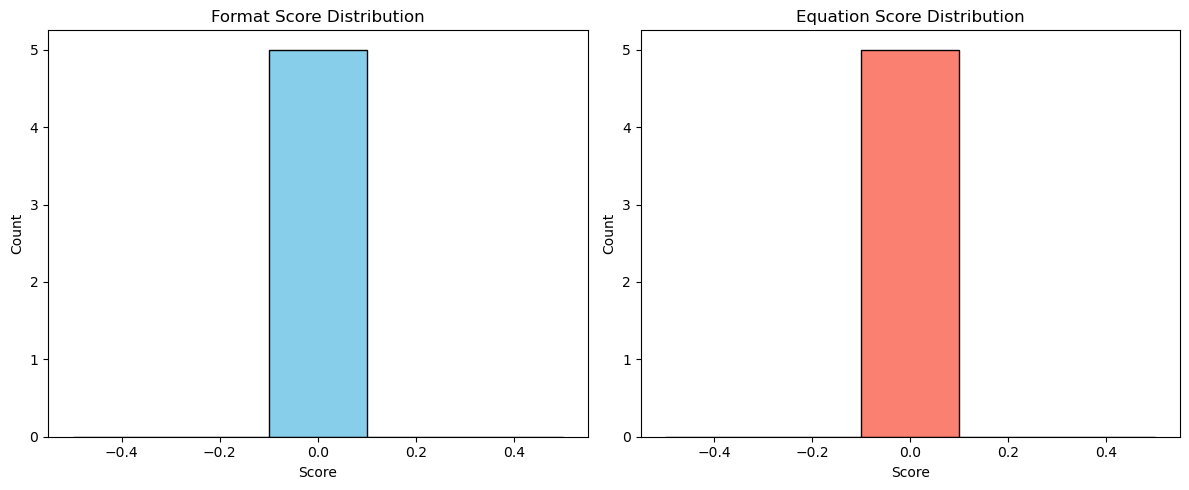

In [40]:
import json
import matplotlib.pyplot as plt

# Load evaluation results
with open("evaluation_results.json", "r") as f:
    data = json.load(f)

# Display overall metrics
metrics = data["metrics"]
print("📊 Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

# Show examples with low and high reward
examples = data["examples"]
sorted_examples = sorted(examples, key=lambda x: x["equation_score"] + x["format_score"])

print("\n❌ Example with lowest score:")
print(json.dumps(sorted_examples[0], indent=2))

print("\n✅ Example with highest score:")
print(json.dumps(sorted_examples[-1], indent=2))

# Histogram of reward distribution
format_scores = [ex["format_score"] for ex in examples]
equation_scores = [ex["equation_score"] for ex in examples]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(format_scores, bins=5, color='skyblue', edgecolor='black')
plt.title("Format Score Distribution")
plt.xlabel("Score"); plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(equation_scores, bins=5, color='salmon', edgecolor='black')
plt.title("Equation Score Distribution")
plt.xlabel("Score"); plt.ylabel("Count")

plt.tight_layout()
plt.show()


## 7. (Optional) Deploy the model

After training completes, you can deploy the model to a SageMaker endpoint for inference. This is optional and can be done later.

In [ ]:
# Uncomment to deploy the model
# predictor = estimator.deploy(
#    initial_instance_count=1,
#    instance_type='ml.g5.xlarge',
#    endpoint_name='countdown-grpo-endpoint'
# )